# Classification tree for diabetes

#### Response
**DIABBC**:
Only diabetes currently and healthy(never has diabetes) are presented here. relatively few diabetes quit and these observations (around 50 ppl) have been excluded from the data
  
- Yes(1) : Ever told has diabetes mellitus, still current and long term
- No(0) : Never told has diabetes mellitus


### Predictors: 
"DIABBC",  "AGEC","SEX", "INCDEC", "EXLWTBC", "BMISC", "DIETRDI","ZINCT_MEAN", "RedMeat_indicator", "SELT_MEAN"


#### Dataset:
- remove missing values
- remove outliers
- remove children (age < 18)
- remove currently pregnant (sabdyms = 4)
- remove the group DIABBC = 3 as too few people in this group

### Model Goal:
Predict whether or not a patient has diabetes, based on certain diagnostic measurements


# Result：
With 30% data as the test data, the overall accuracy (correct prediction) is around 75%
From the tree below we can see that: 
1. **The most important predictors are `AGE`, `BMISC`, `INCDEC`**
2. **The other important variables are `SELT_MEAN`, and `ZINCT_MEAN`**
3. **Other variable seems not useful: Vegan_indicator, RedMeat_indicator, DIETRDI, EatingType**


In [1]:
knitr::opts_chunk$set(echo = TRUE)

options(warn=-1, digits=3) 

library <- function(...) {
  suppressPackageStartupMessages(base::library(...))
}

# Data cleaning packages
library(tidyverse)
library(here)
library(janitor)
library(knitr)


# Helper packages
library(dplyr)       # for data wrangling
library(ggplot2)     # for awesome plotting

# Modeling packages
library(rpart)       # direct engine for decision tree application
library(caret)       # meta engine for decision tree application

# Model interpretability packages
library(rpart.plot)  # for plotting decision trees
library(vip)         # for feature importance
library(pdp)         # for feature effects
 
set.seed(1)

In [7]:
tib <- read.csv(here("data", "selected_columns_5Nov.csv"))

# Perform some data cleaning and subset variables to make modelling easier.
tib <- tib %>% 
  #clean_names() %>% 
  na.omit()  # Perform a quick and dirty complete case analysis

# Change some variables to factors that should be factors
tib$Diabetes <- ifelse(tib$Diabetes == '1', 1, 0)
#tib$DIABBC <- factor(tib$DIABBC )

In [8]:
DT::datatable(tib[1:100,])

HTML widgets cannot be represented in plain text (need html)

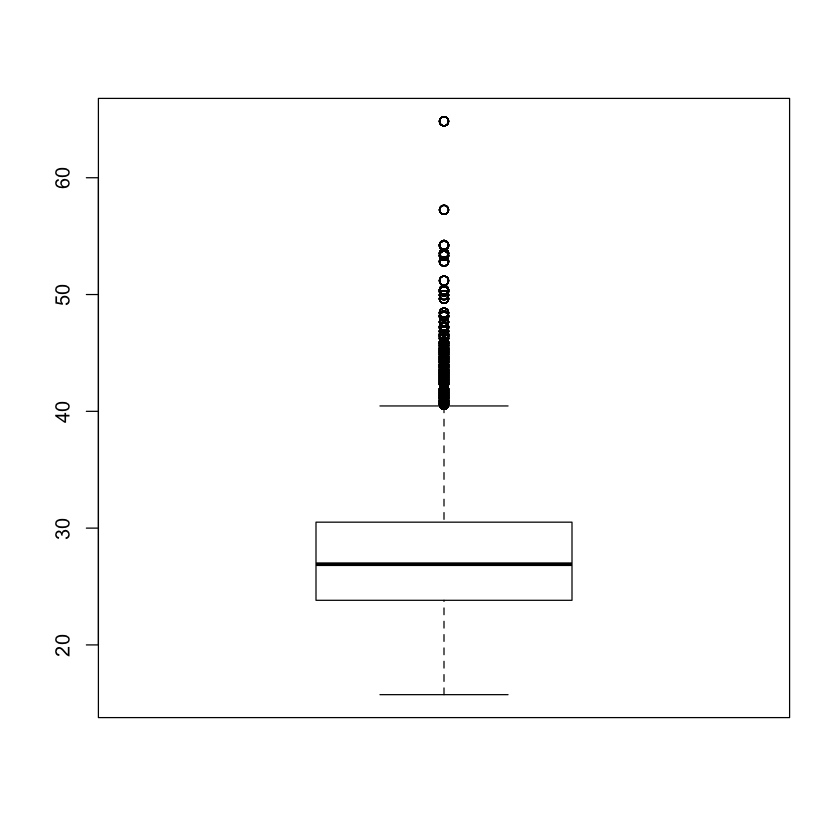

In [10]:
boxplot(tib$BMI)

### Split train and test dataset

In [4]:
require(caTools)  # loading caTools library
set.seed(123)   #  set seed to ensure you always have same random numbers generated
sample = sample.split(tib,SplitRatio = 0.8) # splits the data in the ratio mentioned in SplitRatio.
tib_train =subset(tib,sample ==TRUE) # creates a training dataset named train1 with rows which are marked as TRUE
tib_test =subset(tib, sample==FALSE)

Loading required package: caTools



## Decision Tree 1: Fit decision Tree from Top to Down

#### Fit classification tree using cross-entropy

Ues the `parms = list(split="information")` in rpart to fit the classification tree 
(with DIABBC as the response) using cross-entropy loss (as oppose to the default gini).

#### rpart
Recursive Partitioning And Regression Trees

Use the plotcp function to observe the value of `cp` for different tree depths
(note that the relative error is determined by cross-validation with default
`xval=10` folds that can be changed using the `rpart.control()` function).

In [12]:
# Train tree
# observe the value of cp for different tree depths
res1 <- rpart(Diabetes~.,data=tib, 
              parms = list(split="information")) # optional parameters for the splitting function 
# The splitting index can be gini or information

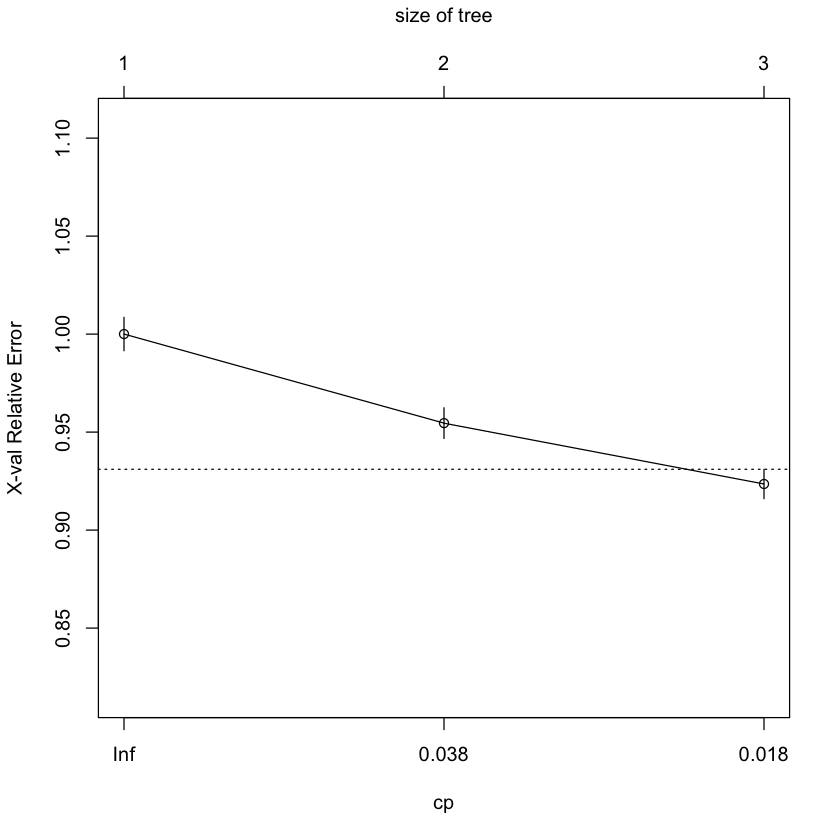

In [13]:
plotcp(res1)

The above figure shows a  pruning **complexity parameter (cp) plot** illustrating the relative cross 
validation error (y-axis) for various cp values (lower x-axis). 
- **Using the 1-SE rule (calculated via cross-validation), a tree size of about 16 is optimal** (in terms of cross-validation).
- From result below we can see that the suggested size of tree = 3, and only two variables `AGEC` and `BMISC` are selected.

In [14]:
tab1 <- printcp(res1)


Regression tree:
rpart(formula = Diabetes ~ ., data = tib, parms = list(split = "information"))

Variables actually used in tree construction:
[1] Age BMI

Root node error: 10282/163851 = 0.06

n= 163851 

    CP nsplit rel error xerror  xstd
1 0.05      0       1.0    1.0 0.009
2 0.03      1       1.0    1.0 0.008
3 0.01      2       0.9    0.9 0.007


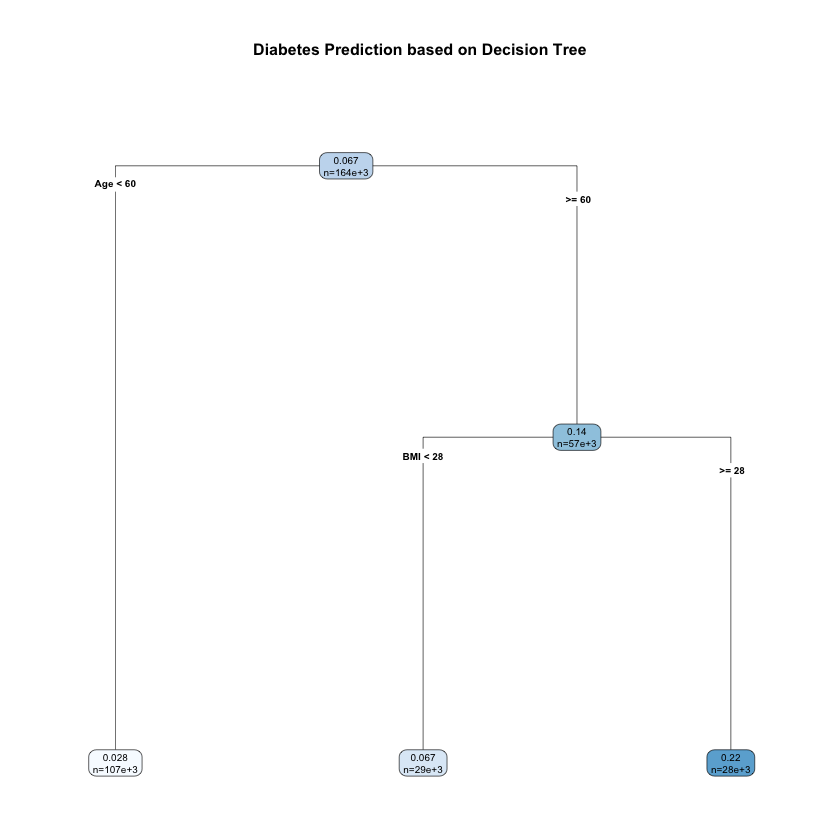

In [15]:
# Plot the fitted tree. 
# visualize the fited model
rpart.plot(res1, 
           type=4, # differernt tree type for visualization
           extra=1, 
           main="Diabetes Prediction based on Decision Tree",
           cex=0.5)

## Decision Tree 2: Try to build a more complex Decision Tree (from bottom to Top)

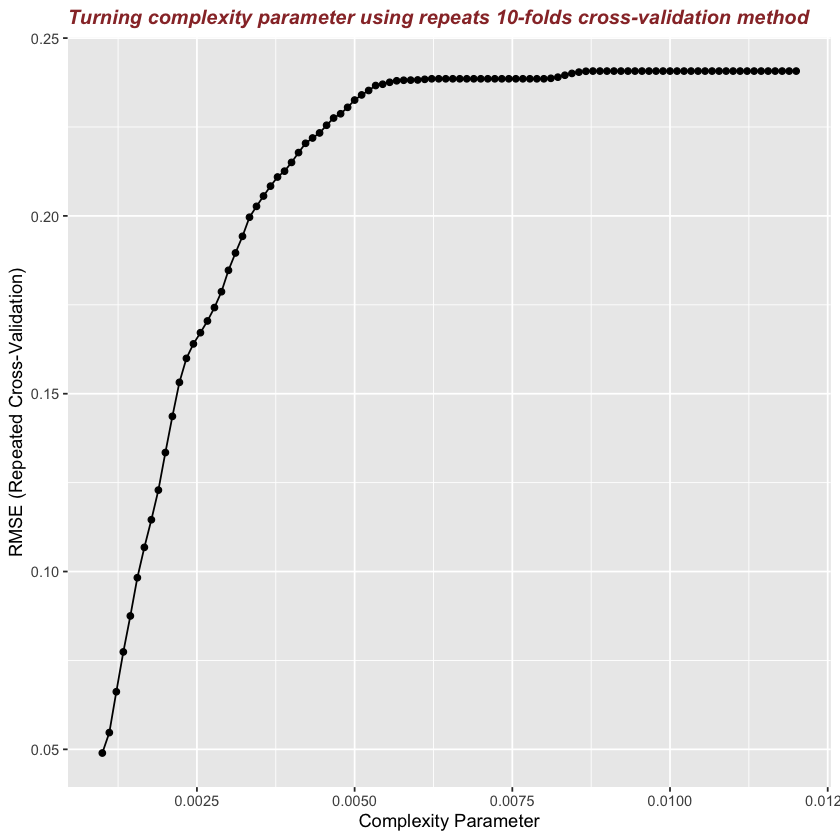

In [54]:
n_grid <- 100
tuneGrid <- expand.grid(cp = seq(0.012, 0.001, length=n_grid))
#tib$account_type <- as.factor(tib$account_type) # convert to categorical variable
dt <- train(
  Diabetes ~ .,
  data = tib,
  method = "rpart",
  trControl = trainControl(method = "repeatedcv", 
                           number = 10,
                           repeats = 10),
  tuneGrid = tuneGrid)

p <- ggplot(dt) + ggtitle("Turning complexity parameter using repeats 10-folds cross-validation method ")
p + theme(plot.title = element_text(color="#993333", size=12, face="bold.italic"))

In [39]:
# Use the prune function with a cp value of 0.0017 to prune the full tree fit.
rpart_cont <- rpart.control(cp = 0) # Various parameters that control aspects of the rpart fit.
res2 <- rpart(Diabetes~.,data=tib, 
              control = rpart_cont,
              parms = list(split="information"))
res3 <- prune.rpart(res2, cp = 0.005)

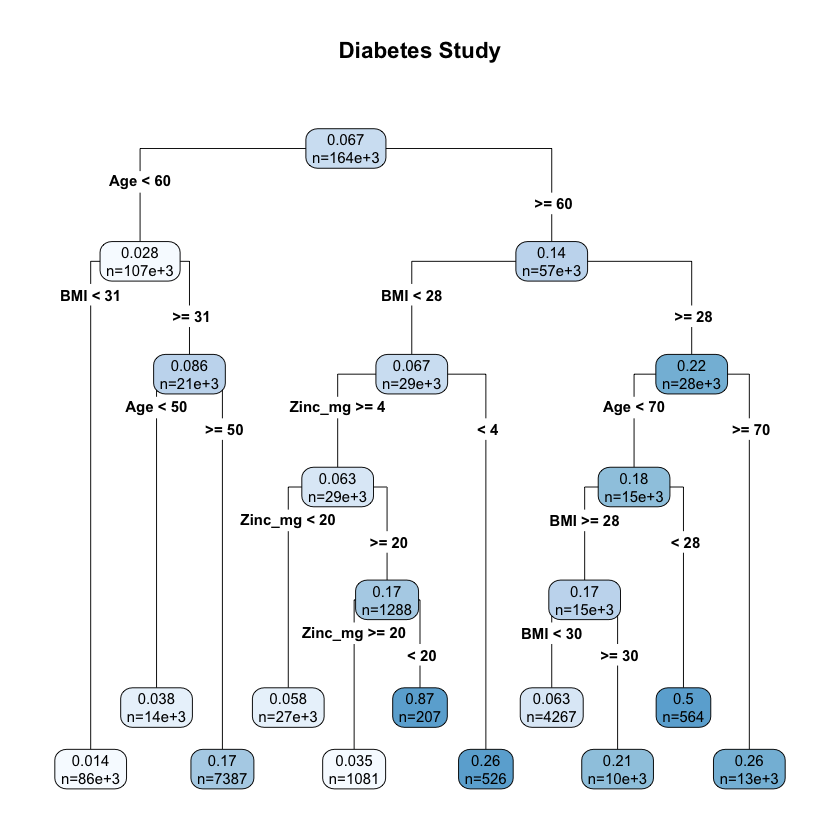

In [40]:
rpart.plot(res3, type=4,extra=1, main="Diabetes Study",cex=0.75)

### Decision Tree interpretation

- At the top, it is the overall probability of Diabetes. It shows the proportion of ppl that get diabetes. (6.7%)-
- On the next level, it ask if the ppl's age < 60, if yes, the proportion of ppl that get diabetes is 2.8%. 
- keep the same logic for interpretation 

### Variable importance based on decision Tree
Let's have a look at the variable importance scores for the top variables.

- We can see that the top 5 important variables are `AGEC`, `BMISC`, `ZINCT_MEAN`, `INCDMEC`, and `ZINCT_MEAN`

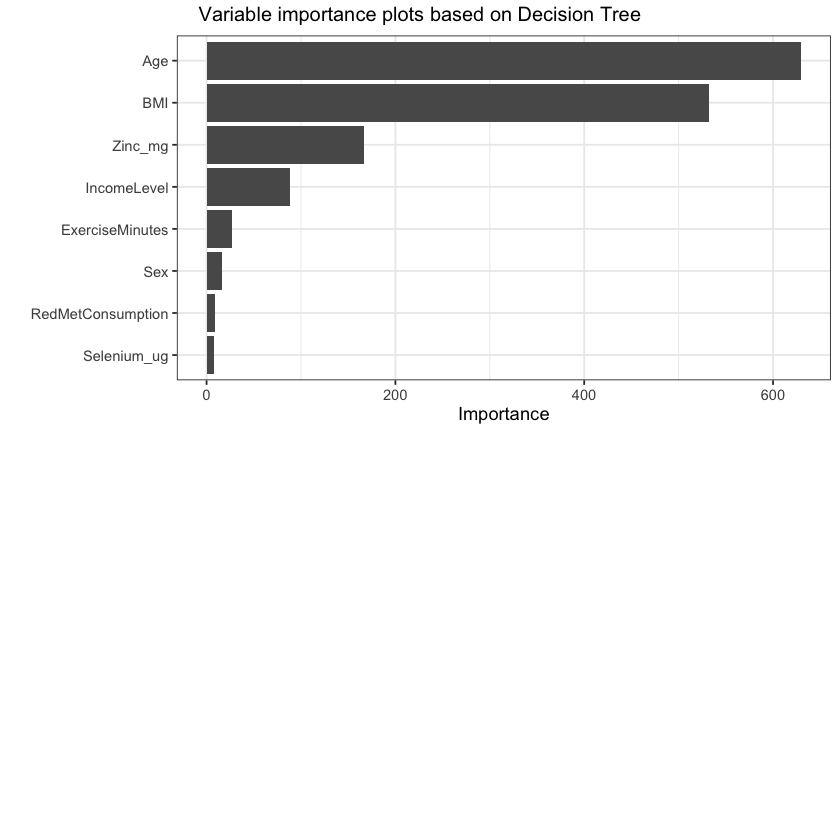

In [26]:
g <- vip(res3, num_features = 10) + theme_bw()
gridExtra::grid.arrange(g, nrow = 2, top = "Variable importance plots based on Decision Tree") 

In [27]:
colnames(tib)

[1] "Diabetes"                        "Age"                            
 [3] "Sex"                             "IncomeLevel"                    
 [5] "ExerciseMinutes"                 "BMI"                            
 [7] "MetRecommendedDietaryGuidelines" "Zinc_mg"                        
 [9] "RedMetConsumption"               "Selenium_ug"

### partial dependence plots
To interpret the marginal effects of plots we can use partial dependence plots.

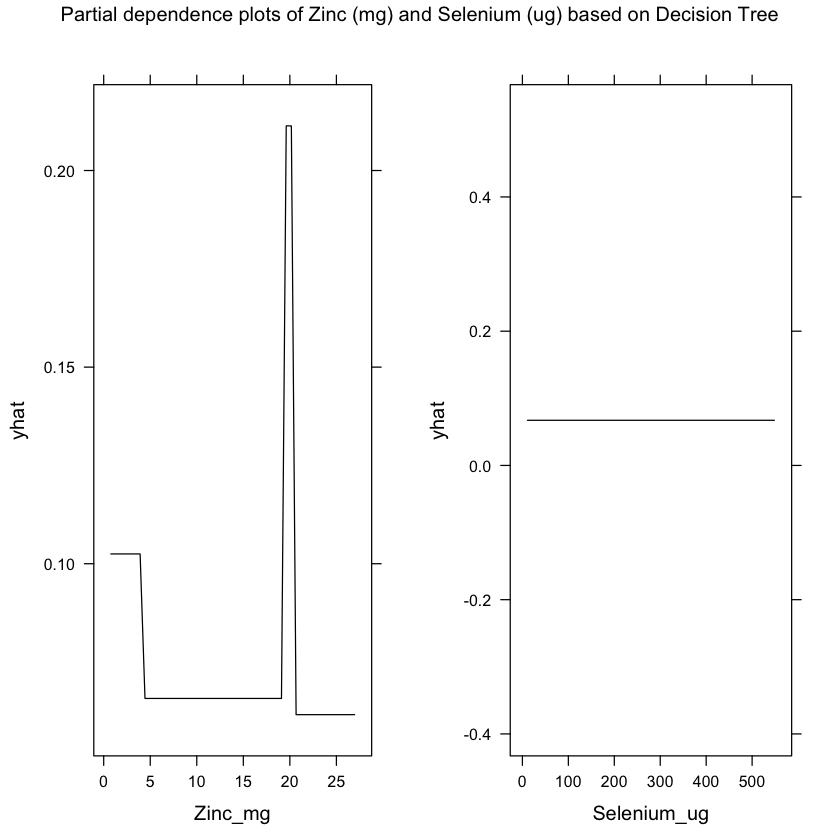

In [41]:
p1 <- partial(res3, pred.var = "Zinc_mg", prob=TRUE, plot=TRUE) 
p2 <- partial(res3, pred.var = "Selenium_ug", prob=TRUE, plot=TRUE) 

gridExtra::grid.arrange(p1, p2,nrow = 1, 
                        top = "Partial dependence plots of Zinc (mg) and Selenium (ug) based on Decision Tree")



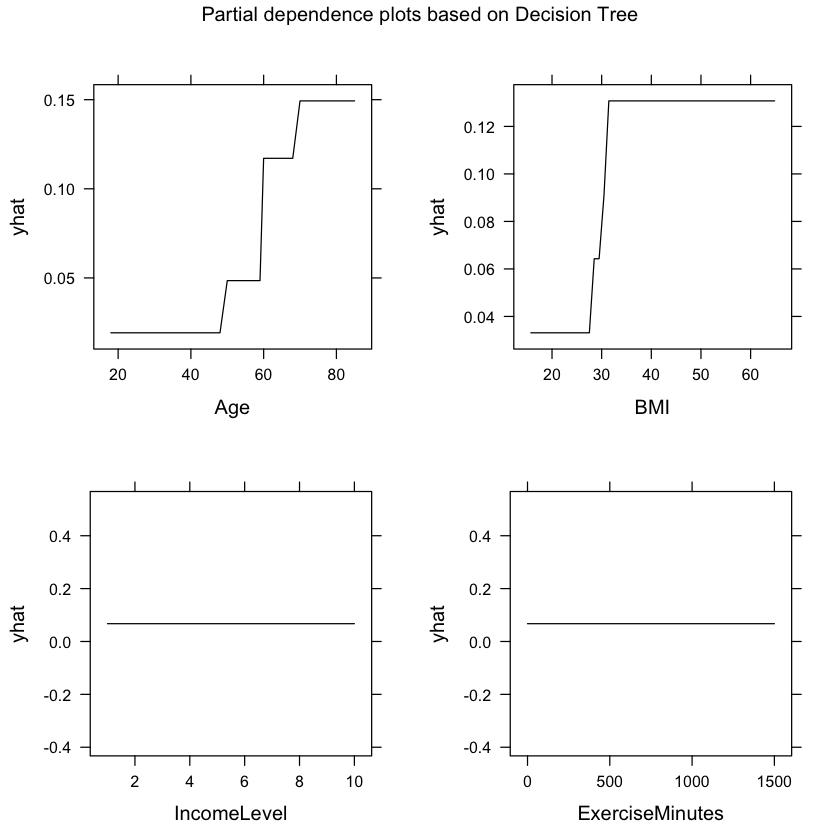

In [43]:
# Partial dependence plots based on Decision Tree
### plot the VIP scores
p1 <- partial(res3, pred.var = "Age", prob=TRUE, plot=TRUE) 
p2 <- partial(res3, pred.var = "BMI", prob=TRUE, plot=TRUE) 
p3 <- partial(res3, pred.var = "IncomeLevel", prob=TRUE, plot=TRUE)
p4 <- partial(res3, pred.var = "ExerciseMinutes", prob=TRUE, plot=TRUE)

gridExtra::grid.arrange(p1, p2, p3, p4, nrow = 1, top = "Partial dependence plots based on Decision Tree") 

# 上面这个图非常重要，
From the plot above we can see that:
- when `ZINCT_MEAN` < 5 or  18 <`ZINCT_MEAN` < 21, the ppl are more likely(higher probability) get diabetes.
- By contrast, the probability of get diabetes increase as the SELT increase

# 不确定prediction的时候threshold 怎么确定，需要问老师

## Test decision Tree accuracy (based on the simplest model)

based on the prediction on the `model3`:
- the model accuracy is **81%**, which means that we can predict 81% new observation correctly based on this model
- the "Balanced Accuracy" is **75.7%**

In [18]:
predict_unseen <- predict(res3, tib_test, type = "vector") >= 0.1 # set threshold = 0.1 
predict_unseen <- ifelse(predict_unseen == "TRUE",1,0)

In [19]:
confusionMatrix(as.factor(predict_unseen),as.factor(tib_test$DIABBC))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 25058   673
         1  5512  1527
                                        
               Accuracy : 0.811         
                 95% CI : (0.807, 0.815)
    No Information Rate : 0.933         
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.254         
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.820         
            Specificity : 0.694         
         Pos Pred Value : 0.974         
         Neg Pred Value : 0.217         
             Prevalence : 0.933         
         Detection Rate : 0.765         
   Detection Prevalence : 0.785         
      Balanced Accuracy : 0.757         
                                        
       'Positive' Class : 0             
                                        

# Random Forest

Try to use multiple trees to model data better

In [45]:
# Modeling packages
library(ranger)  

# number of features
n_features <- length(setdiff(names(tib), "Diabetes"))

# train a default random forest model
res6 <- ranger(
  Diabetes~.,data=tib, 
  mtry = floor(n_features / 3),
  respect.unordered.factors = "order",
  seed = 123
)

# get OOB error
prediction_error <- res6$prediction.error
print("OOB error is :", prediction_error)

[1] "OOB error is :"


### Turning hyperparameters of RF
Next we will tune the RF by creating a hyperparameter grid
with some (hopefully reasonable) values of `mtry` the number
of variables to randomly select at each splot, the 
`min.node.size` (`minbucket` in rpart), whether to sample
with or without replaement (`replace`), and the sample fraction.


In [46]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  mtry = floor(n_features * c(.05, .15, .25, .333, .4)), # number of variables to randomly select at each splot
  min.node.size = c(1, 3, 5), # minbucket
  replace = c(TRUE, FALSE), # with or without replaement                             
  sample.fraction = c(.5, .63, .8),                       
  error = NA                                               
)

In [47]:
# execute full cartesian grid search
for(i in seq_len(nrow(hyper_grid))) {
  # fit model for ith hyperparameter combination
  fit <- ranger(
    formula         = Diabetes~., 
    data            = tib,
    num.trees       = n_features * 5,
    mtry            = hyper_grid$mtry[i],
    min.node.size   = hyper_grid$min.node.size[i],
    replace         = hyper_grid$replace[i],
    sample.fraction = hyper_grid$sample.fraction[i],
    verbose         = FALSE,
    seed            = 123,
    respect.unordered.factors = 'order',
  )
  # export OOB error 
  hyper_grid$error[i] <- fit$prediction.error
}


In [48]:
# assess top 10 models
hyper_grid %>%
  arrange(error) %>%
  head(10)

,mtry,min.node.size,replace,sample.fraction,error
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1,0,1,FALSE,0.50,3.63e-05
2,3,1,FALSE,0.50,3.63e-05
3,0,3,FALSE,0.50,3.63e-05
4,3,3,FALSE,0.50,3.63e-05
5,0,5,FALSE,0.50,3.63e-05
6,3,5,FALSE,0.50,3.63e-05
7,0,1,TRUE,0.63,3.66e-05
8,3,1,TRUE,0.63,3.66e-05
9,0,3,TRUE,0.63,3.66e-05


From table above, we can see that we shall choice:
- sample.fraction = 0.5
- replace = true
- min.node.size = 5
- mtry( the number of variables to randomly select at each splot) = 3

### variance important scores
Next we use the `ranger` package to calculate the variance important
scores using an `impurity` and a `permutation` approach.

In [50]:
# re-run model with impurity-based variable importance
rf_impurity <- ranger(
  formula = Diabetes~., 
    data = tib,
  num.trees = n_features * 5,
  mtry = 3,
  min.node.size = 5,
  sample.fraction = .50,
  replace = FALSE,
  importance = "impurity",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)

In [51]:
# re-run model with permutation-based variable importance
rf_permutation <- ranger(
  formula = Diabetes~., 
    data = tib,
  num.trees = n_features * 5,
  mtry = 3,
  min.node.size = 5,
  sample.fraction = .50,
  replace = FALSE,
  importance = "permutation",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)

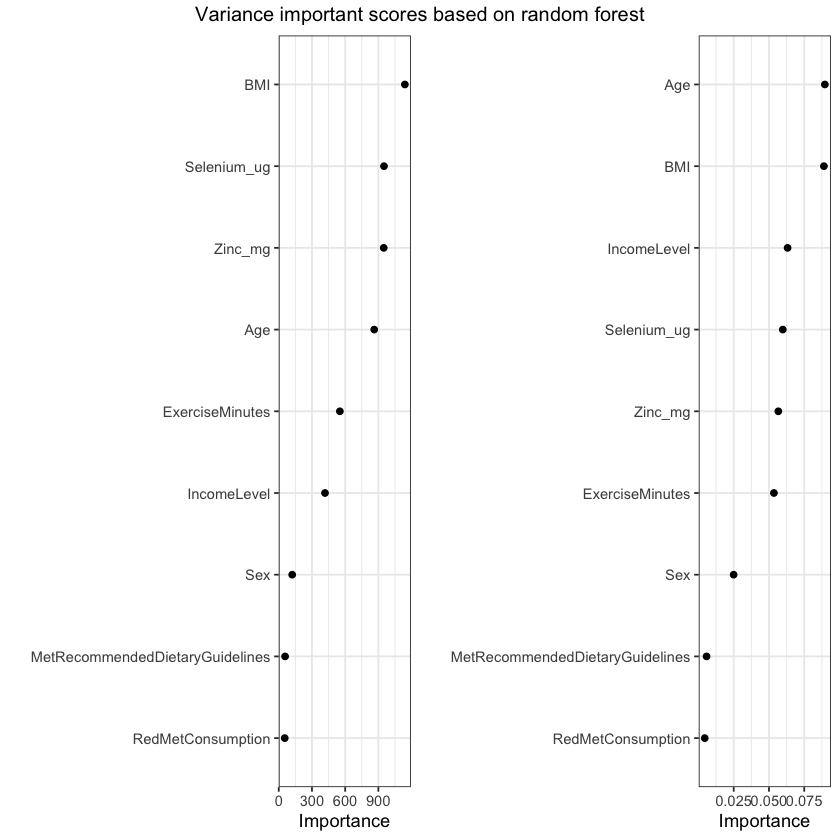

In [53]:
### plot the VIP scores
p1 <- vip::vip(rf_impurity, num_features = 10, bar = FALSE) + theme_bw()
p2 <- vip::vip(rf_permutation, num_features = 10, bar = FALSE) + theme_bw()

gridExtra::grid.arrange(p1, p2, nrow = 1, top = "Variance important scores based on random forest")

From the plot above, we can see that using RF:
1. the top 5 most important variables measured on `impurity` are `BMISE`, `SELT_MEAN`, `ZINT_MEAN`, `AGEC`, and `EXTWTBC`
2.  the top 5 most important variables measured on `permutation` are  `AGEC`, `BMISE`, `INCDEC`, `SELT_MEAN`, `ZINT_MEAN`
3. Thus, **the robust important variables are `BMISE`, `SELT_MEAN`, `ZINT_MEAN`, `AGEC`**

# 这个结论非常重要，明天整理一下写在开头

In [27]:
### best fit model after hyper-parameter turning

# train a default random forest model
res7 <- ranger(
  formula = Diabetes~., 
  data = tib,
  num.trees = n_features * 5,
  mtry = 3,
  min.node.size = 5,
  sample.fraction = .50,
  replace = FALSE,
  importance = "impurity",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)


### Test RF accuracy

In [28]:
predict_unseen <- predict(res7, tib_test) #, type = "vector") >= 0.1 # set threshold = 0.1 
predict_unseen <- ifelse(predict_unseen$predictions >= 0.5, 1, 0)
confusionMatrix(as.factor(predict_unseen),as.factor(tib_test$DIABBC))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30570     0
         1     0  2200
                                
               Accuracy : 1     
                 95% CI : (1, 1)
    No Information Rate : 0.933 
    P-Value [Acc > NIR] : <2e-16
                                
                  Kappa : 1     
                                
 Mcnemar's Test P-Value : NA    
                                
            Sensitivity : 1.000 
            Specificity : 1.000 
         Pos Pred Value : 1.000 
         Neg Pred Value : 1.000 
             Prevalence : 0.933 
         Detection Rate : 0.933 
   Detection Prevalence : 0.933 
      Balanced Accuracy : 1.000 
                                
       'Positive' Class : 0     
                                

## RF model without Zn and Se

这个model有问题，因为accuracy也是1

let's see how the model performance without Zn and Se

In [29]:
drops <- c("SELT_MEAN", "ZINT_MEAN")
tib_test = tib_test[ , !(names(tib_test) %in% drops)]
tib_train = tib_train[ , !(names(tib_train) %in% drops)]

In [30]:
# number of features
n_features <- length(setdiff(names(tib), "DIABBC"))

# execute full cartesian grid search
for(i in seq_len(nrow(hyper_grid))) {
  # fit model for ith hyperparameter combination
  fit <- ranger(
    formula         = DIABBC~., 
    data            = tib_train,
    num.trees       = n_features * 5,
    mtry            = hyper_grid$mtry[i],
    min.node.size   = hyper_grid$min.node.size[i],
    replace         = hyper_grid$replace[i],
    sample.fraction = hyper_grid$sample.fraction[i],
    verbose         = FALSE,
    seed            = 123,
    respect.unordered.factors = 'order',
  )
  # export OOB error 
  hyper_grid$error[i] <- fit$prediction.error
}


In [31]:
# assess top 10 models
hyper_grid %>%
  arrange(error) %>%
  head(10)

,mtry,min.node.size,replace,sample.fraction,error
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1,3,1,FALSE,0.50,0.000101
2,3,3,FALSE,0.50,0.000101
3,3,5,FALSE,0.50,0.000101
4,3,1,TRUE,0.80,0.000127
5,3,3,TRUE,0.80,0.000127
6,3,5,TRUE,0.80,0.000127
7,3,1,TRUE,0.50,0.000132
8,3,3,TRUE,0.50,0.000132
9,3,5,TRUE,0.50,0.000132


In [32]:
### best fit model after hyper-parameter turning

# train a default random forest model
res8 <- ranger(
  formula = DIABBC~., 
  data = tib_train,
  num.trees = n_features * 5,
  mtry = 3,
  min.node.size = 5,
  sample.fraction = .50,
  replace = TRUE,
  importance = "impurity",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)


In [33]:
predict_unseen <- predict(res8, tib_test) #, type = "vector") >= 0.1 # set threshold = 0.1 
predict_unseen <- ifelse(predict_unseen$predictions >= 0.5, 1, 0)
confusionMatrix(as.factor(predict_unseen),as.factor(tib_test$DIABBC))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30570     0
         1     0  2200
                                
               Accuracy : 1     
                 95% CI : (1, 1)
    No Information Rate : 0.933 
    P-Value [Acc > NIR] : <2e-16
                                
                  Kappa : 1     
                                
 Mcnemar's Test P-Value : NA    
                                
            Sensitivity : 1.000 
            Specificity : 1.000 
         Pos Pred Value : 1.000 
         Neg Pred Value : 1.000 
             Prevalence : 0.933 
         Detection Rate : 0.933 
   Detection Prevalence : 0.933 
      Balanced Accuracy : 1.000 
                                
       'Positive' Class : 0     
                                